In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import disk, label
from skimage.measure import regionprops
from scipy.ndimage.measurements import center_of_mass
from PIL import Image

In [7]:
figsize(24,18)

In [2]:
import positions
reload(positions)

<module 'positions' from 'positions.pyc'>

In [16]:
prefix = 'n352'
imdir = '/Volumes/Walsh_Lab/Squares/equilibrium/'+prefix+'/'
datadir = '/Users/leewalsh/Physics/Squares/orientation/equilibrium_'
basedir = '/Users/leewalsh/Physics/Squares/'
imfiles = {'n400': "n400_2013_11_20_162119.JPG",
           'n352': "n352_2013_11_29_183254.JPG"}

In [4]:
orig = np.asarray(Image.open(imdir+imfiles[prefix]))
data = np.genfromtxt(datadir+prefix+'_POSITIONS.txt', names=True)
cdata = np.genfromtxt(datadir+prefix+'_CORNER_POSITIONS.txt', names=True)
data = data[data['Frame']==0]
cdata = cdata[cdata['Frame']==0]

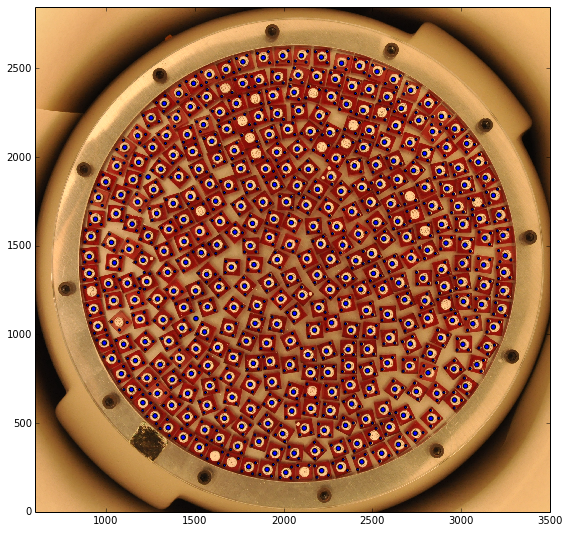

In [22]:
plt.figure(figsize=(8,8), tight_layout=True)
plt.imshow(orig)
plt.scatter(data['Y'], data['X'])
plt.scatter(cdata['Y'], cdata['X'], marker='.')
plt.xlim(600,3500)
plt.ylim(0,len(orig))
plt.savefig(basedir + 'writing/graphics/slr_marked.png')

[[-2 -2 -2 -1 -2 -2 -2]
 [-2 -1 -1 -1 -1 -1 -2]
 [-2 -1  5  7  5 -1 -2]
 [-1 -1  7 12  7 -1 -1]
 [-2 -1  5  7  5 -1 -2]
 [-2 -1 -1 -1 -1 -1 -2]
 [-2 -2 -2 -1 -2 -2 -2]]


(7, 7)

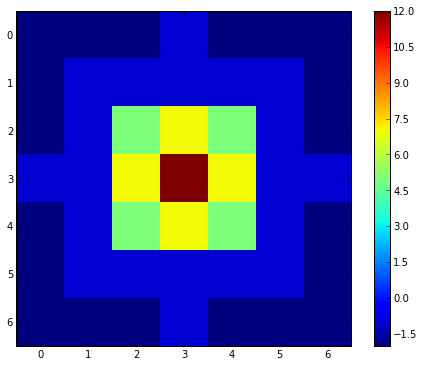

In [18]:
ndisk = disk(3).astype(int) - 2
ndisk[2:-2,2:-2] += disk(1)*2
ndisk[2:-2,2:-2] += disk(2)[1:-1,1:-1]*6
ndisk[3,3] += 5
ndisk.dtype
bsize = 8.5
csize = 2
print ndisk
imshow(ndisk, interpolation='nearest')
colorbar()
ndisk.shape

<matplotlib.colorbar.Colorbar instance at 0x1d87e7fc8>

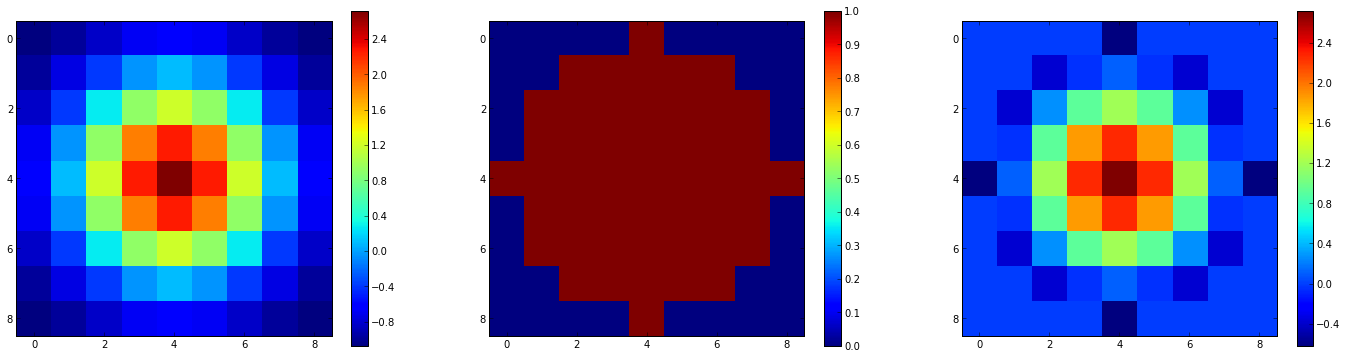

In [583]:
w = 2.*csize
g = np.arange(-w,w+1)
g = np.exp(-.5*g**2/csize**2)
g = np.outer(g,g)
g -= g.mean()
g /= g.std()
figsize(24,6)
subplot(131)
imshow(g, interpolation='nearest')
colorbar()
subplot(132)
imshow(disk(w), interpolation='nearest')
colorbar()
subplot(133)
imshow(g*disk(w), interpolation='nearest')
colorbar()


In [586]:
filtered = ndimage.median_filter(orig, size=2)
removed = positions.remove_disks(filtered, pos, disk(bsize))

In [587]:
#convolved = ndimage.convolve(filtered.astype(int),disk(bsize).astype(int))
#convolveds = ndimage.convolve(removed.astype(int),disk(csize).astype(int))
#convolvedsn = ndimage.convolve(removed.astype(int),ndisk)
#convolvedsnp = convolvedsn.copy()
#convolvedsnp[convolvedsnp<0] = 0
#convolvedsn2 = ndimage.convolve(convolvedsn,ndisk)
convolvedg = ndimage.convolve(removed.astype(float),g)
#convolvedg[convolvedg<0]=0
convolvedg -= convolvedg.min()
convolvedg /= convolvedg.max()

In [588]:
thresh = convolvedg.mean() + 2*convolvedg.std()
print thresh
threshed = label(convolvedg > thresh)

0.462712157961


(array([14,  0, 18,  9, 33, 40, 18,  6, 14, 37]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

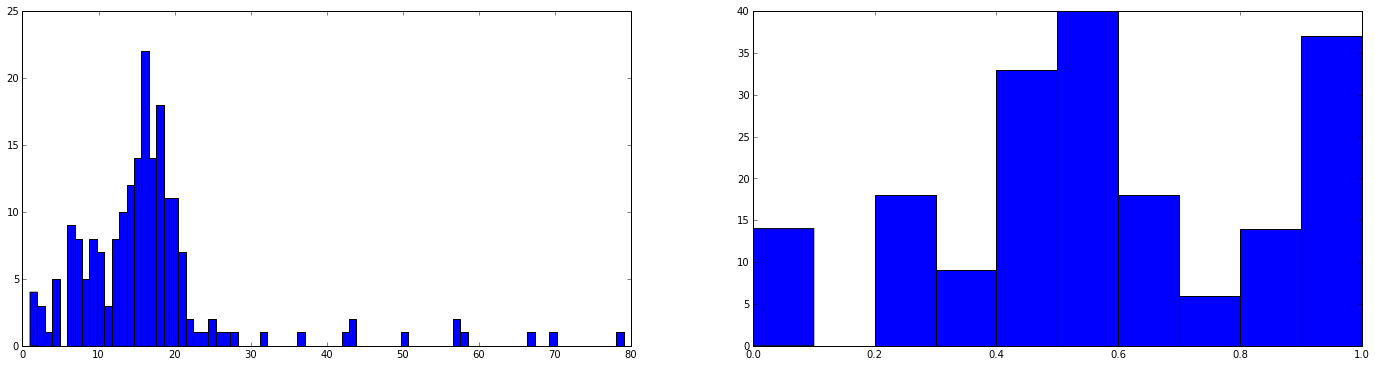

In [599]:
props = regionprops(threshed, ['Area', 'Eccentricity', 'WeightedCentroid'], orig)
figsize(24,6)
subplot(121)
hist([p['Area'] for p in props if p['Area'] < 80],bins=80)
subplot(122)
hist([p['Eccentricity'] for p in props if p['Area'] < 30])

In [589]:
corners_com = center_of_mass(orig, labels=threshed, index=1+np.arange(threshed.max()))
corners_com[0]

(19.349686306862878, 464.82592429155233)

In [433]:
print 'orig:',orig.dtype
print 'filtered:',filtered.dtype
print 'removed:',removed.dtype
print 'g:',g.dtype, '[',g.min(),',',g.max(),']'
print 'convolvedg:',convolvedg.dtype, '[',convolvedg.min(),',',convolvedg.max(),']'
print 'gfiltered:',gfiltered.dtype, '[',gfiltered.min(),',',gfiltered.max(),']'
print 'threshed:',threshed.dtype, '[',threshed.min(),',',threshed.max(),']'

orig: uint8
filtered: uint8
removed: uint8
g: float64 [ -1.07303575919 , 2.71793842516 ]
convolvedg: float64 [ 0.0 , 1.0 ]
gfiltered: float64 [ 0.0 , 1.0 ]
threshed: int64 [ 0 , 216 ]


<matplotlib.colorbar.Colorbar instance at 0x1794059e0>

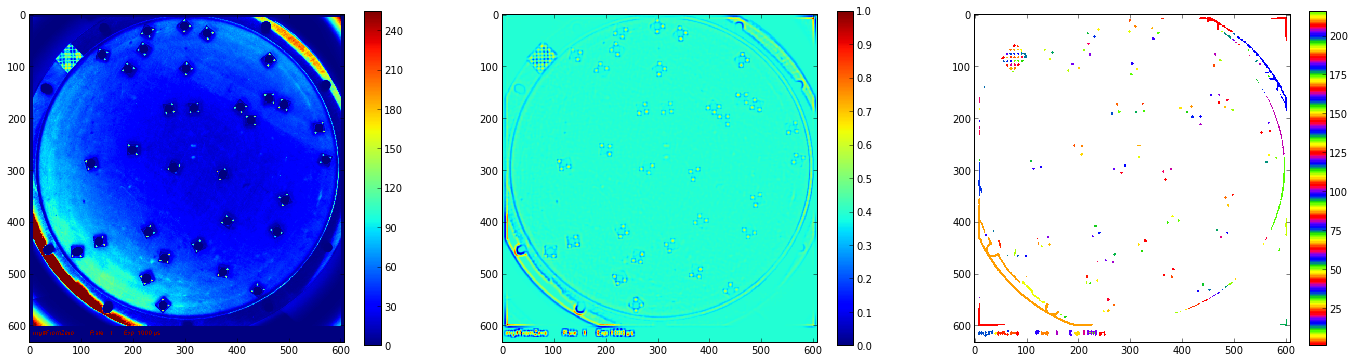

In [590]:
figsize(24,6)
subplot(131)
imshow(removed, interpolation='nearest')
colorbar()
subplot(132)
imshow(convolvedg, interpolation='nearest')
colorbar()
subplot(133)
imshow(np.ma.array(threshed, mask=threshed==0), interpolation='nearest', cmap=cm.prism)
colorbar()

In [431]:
convolvedg.mean()+2*convolvedg.std()

0.46271215796071091

In [513]:
prefix

'still_three_diffuse'

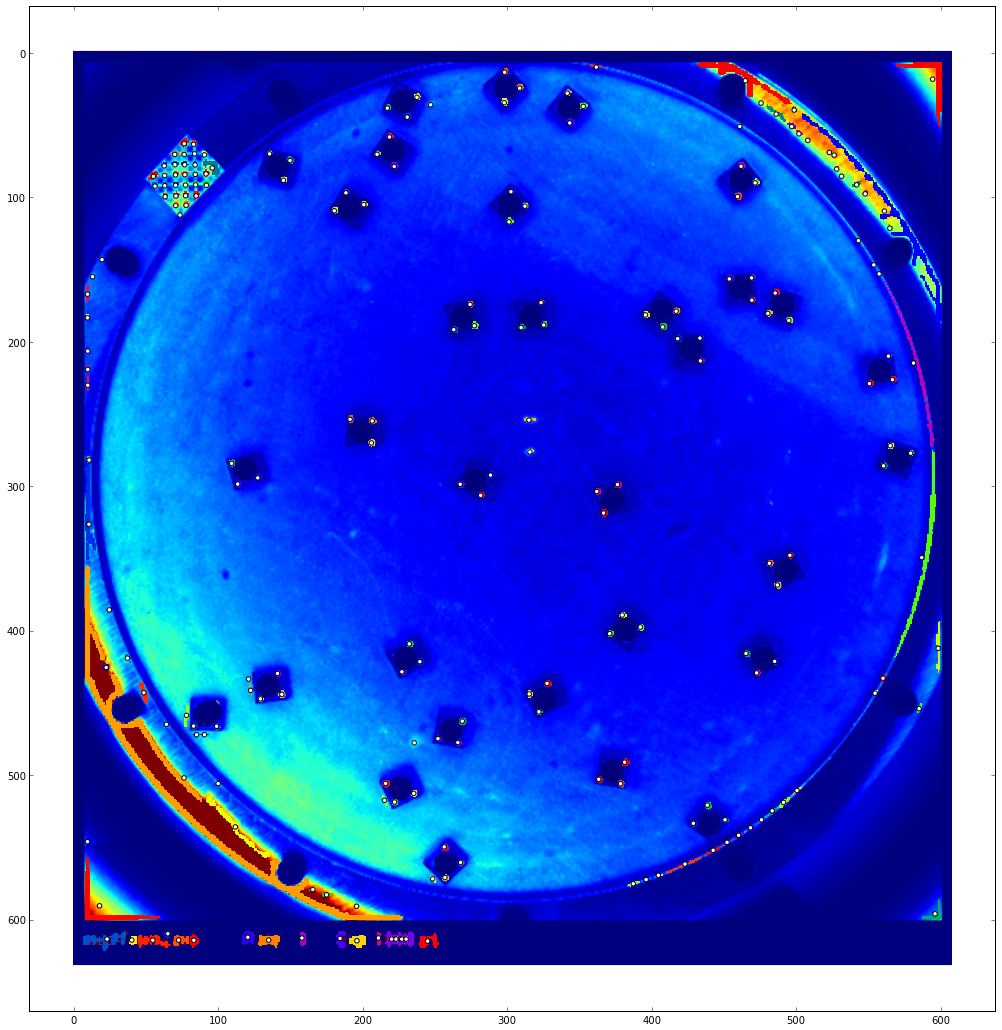

In [591]:
figsize(24,18)
plt.imshow(removed)
plt.imshow(np.ma.array(threshed, mask=threshed==0), interpolation='nearest', cmap=cm.prism)
plt.scatter(*reversed(zip(*corners_com)),c='w')
#savefig('convolvedg.png',dpi=50)

<matplotlib.colorbar.Colorbar instance at 0x11ddd04d0>

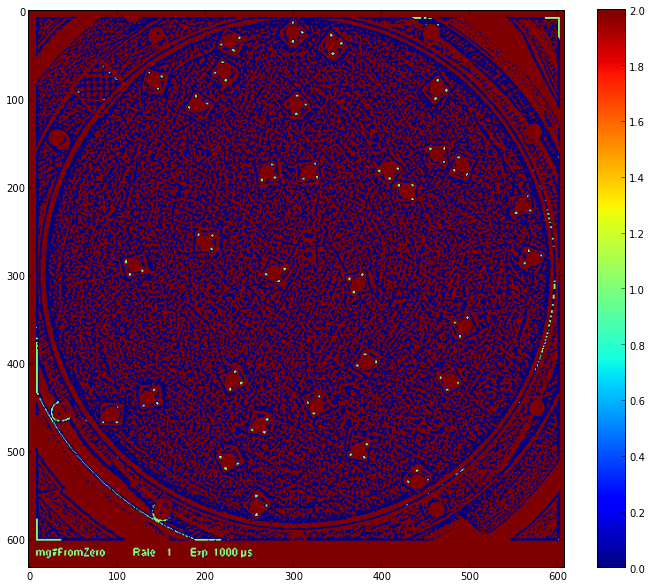

In [119]:
im = convolvedsn.copy()
labels = np.zeros_like(im)
mx = im.max()*.2
mn = im.max()*.0
labels[im>=mx] = 1  #seeds
labels[im<=mn] = 2  #background
imshow(labels)
colorbar()

In [538]:
thresh

0.46271215796071091

<matplotlib.colorbar.Colorbar instance at 0x1cdf25f80>

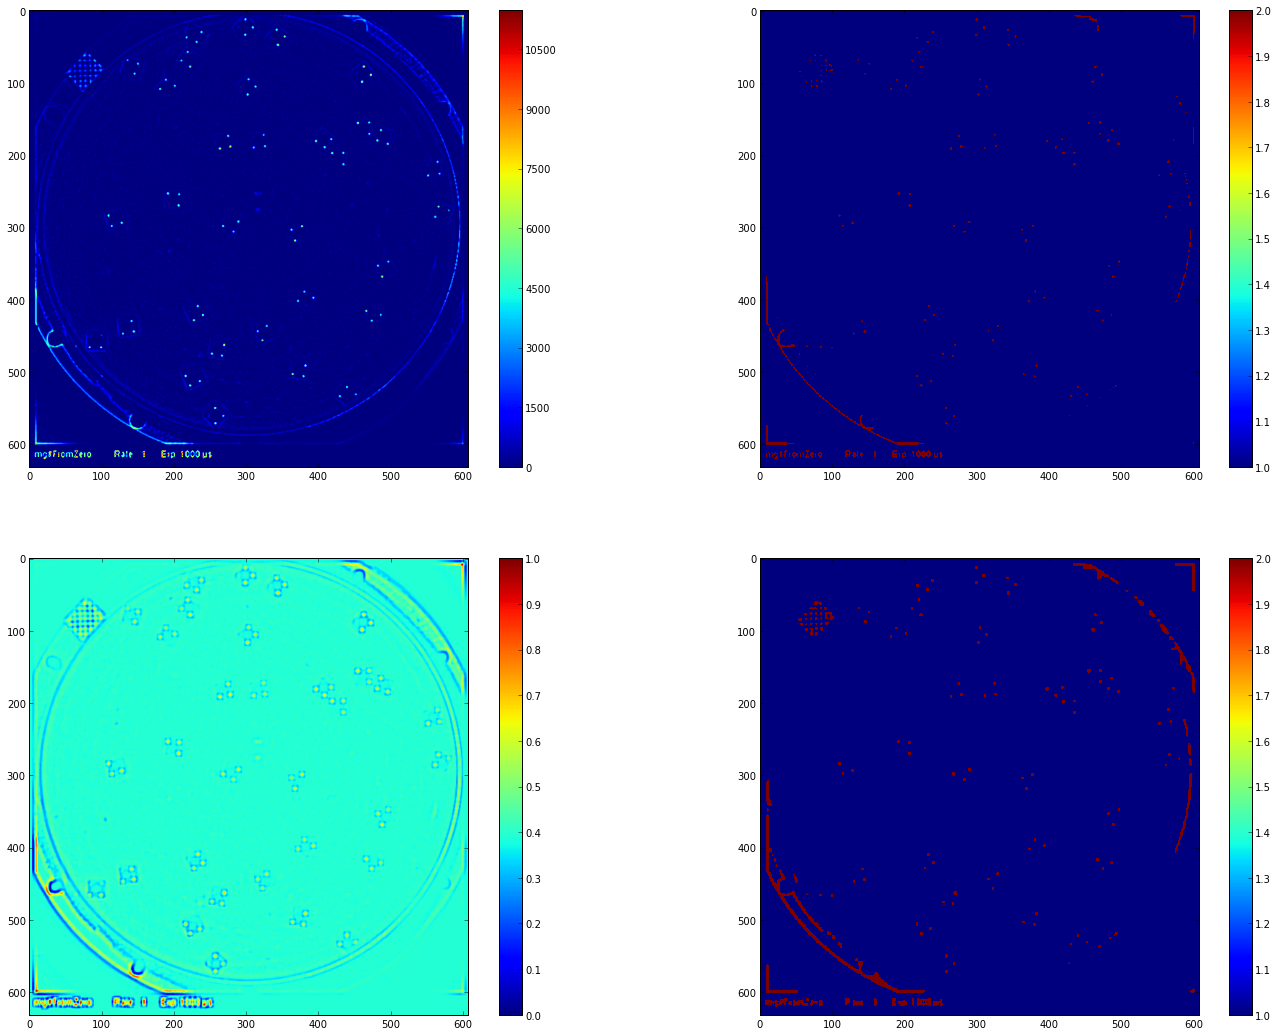

In [572]:
subplot(221)
imshow(convolvedsnp)
colorbar()
walkedsnp = positions.label_particles_walker(convolvedsnp*1.,min_thresh=.1,max_thresh=.2,sigma=0)
subplot(222)
imshow(walkedsnp, interpolation='nearest')
colorbar()

subplot(223)
imshow(convolvedg)
colorbar()
walkedg = positions.label_particles_walker(convolvedg.astype(float),min_thresh=.4,max_thresh=.5,sigma=0)
subplot(224)
imshow(walkedg, interpolation='nearest')
colorbar()